<a href="https://colab.research.google.com/github/OlegKret/LP_Hydropower_Reklaitis/blob/main/ver2_2_LP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 46.0 MB/s eta 0:00:00


Enter the number of time steps (hours) [default: 24]: 24
Enter the number of generators [default: 2]: 2
Enter water inflow type (constant or sinusoid) [default: sinusoid]: sinusoid
Enter base inflow (m^3/s) [default: 50]: 50
Enter inflow amplitude (m^3/s) [default: 10]: 10
Enter electricity price type (constant or sinusoid) [default: sinusoid]: sinusoid
Enter base price ($/MWh) [default: 0.1]: 0.1
Enter price amplitude ($/MWh) [default: 0.01]: 0.01
Enter water usage per MW for each generator (m^3/s/MW) [default: 0.8, 1.2]: 0.8, 1.2
Enter maximum power for each generator (MW) [default: 500, 400]: 500, 400
Enter cost per MWh for each generator ($/MWh) [default: 20, 25]: 20, 25
Enter efficiency for each generator (0-1) [default: 0.9, 0.85]: 0.9, 0.85
Enter minimum power for each generator (MW) [default: 0, 0]: 0, 0

----- Big M Results -----
Status: Optimal
Generator_Power_(0,_0) = 500.0
Generator_Power_(0,_1) = 500.0
Generator_Power_(0,_10) = 500.0
Generator_Power_(0,_11) = 500.0
Generat

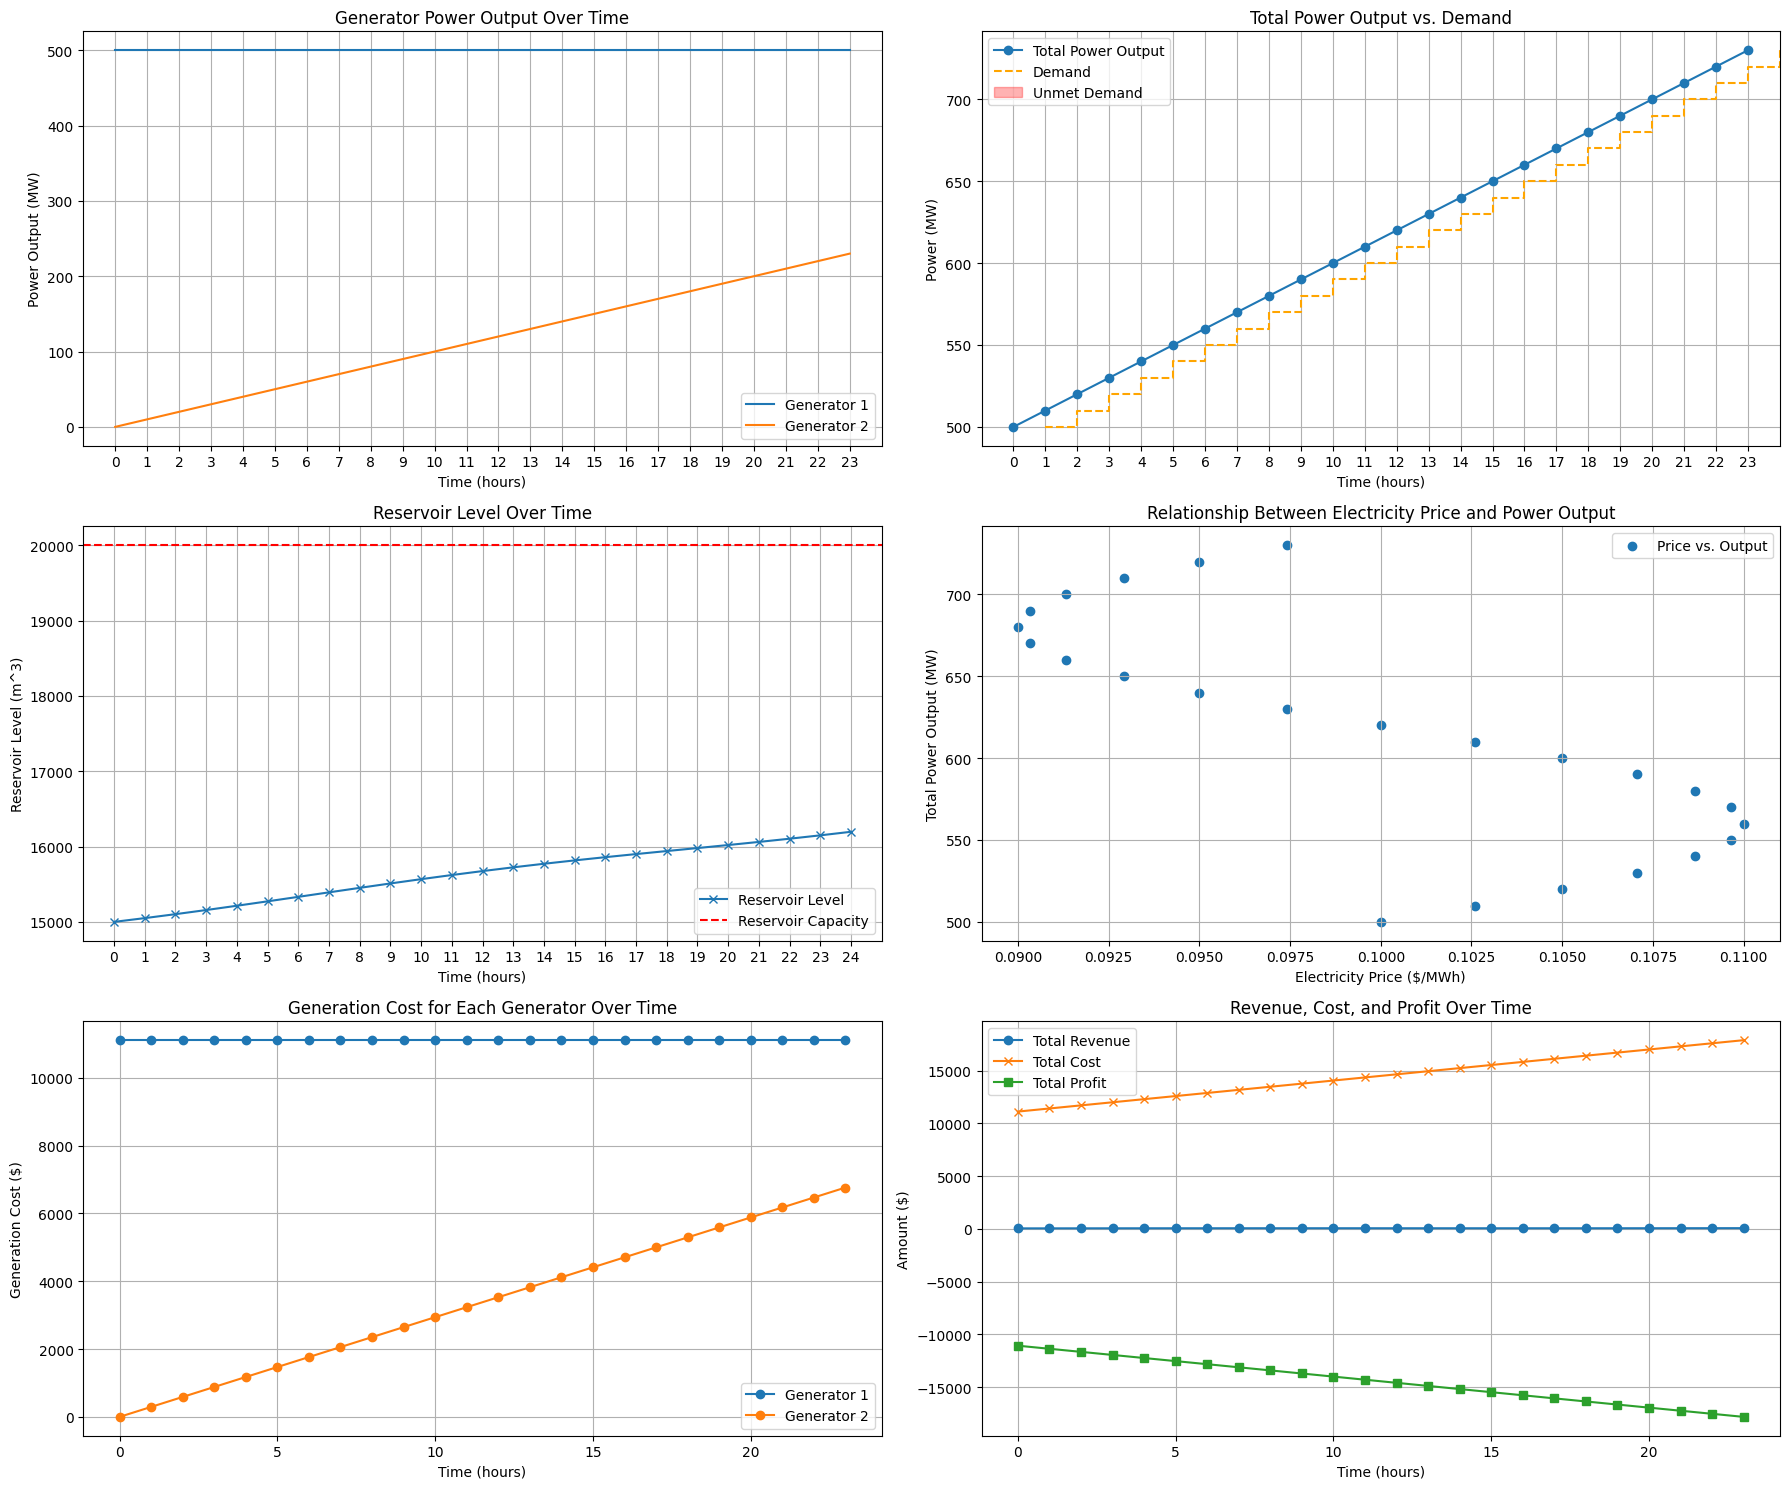

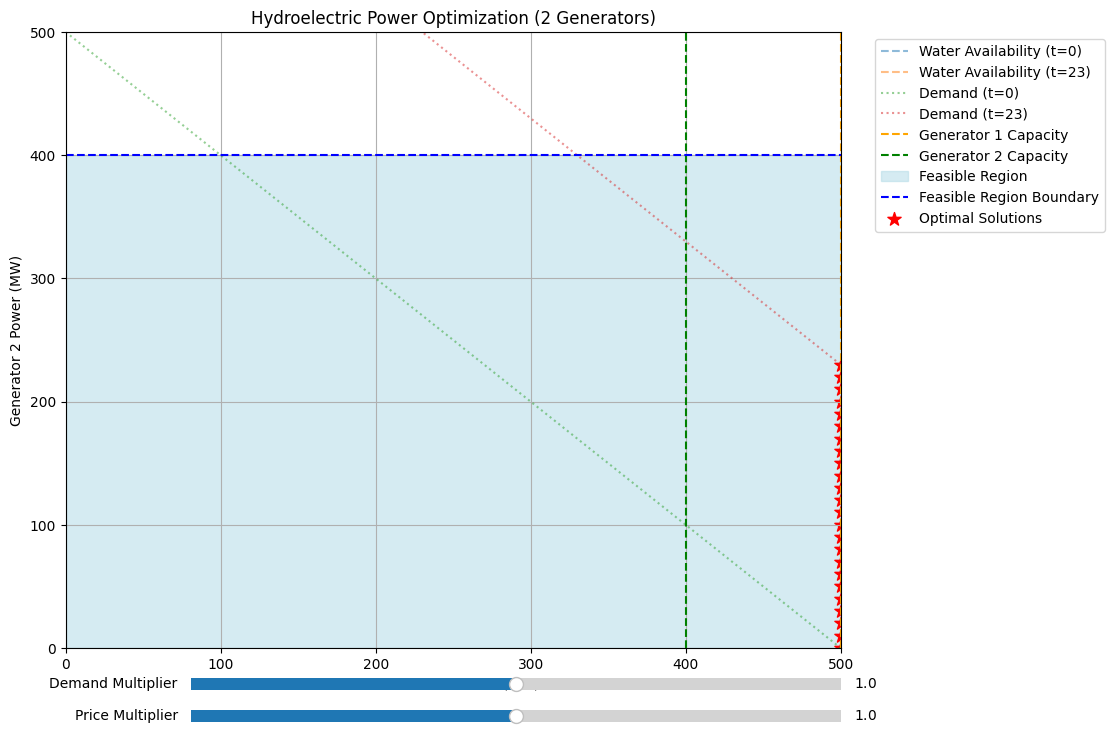

<ipython-input-3-67c02e4633fb>:453: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


In [3]:
import pulp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

# Model Parameters
T = 24  # Number of time steps (hours)
num_generators = 2

# Generator data
water_usage_per_mw = [0.8, 1.2]  # m^3/s per MW for each generator
max_power = [500, 400]            # MW
generator_cost_per_mwh = [20, 25] # $/MWh
generator_efficiency = [0.9, 0.85]
generator_min_power = [0, 0]      # Minimum power output (MW)

# Reservoir Parameters
reservoir_capacity = 20000       # Maximum reservoir capacity (m^3)
initial_reservoir_level = 15000  # Initial water level in the reservoir (m^3)
water_inflow = [50 + 10 * np.sin(2 * np.pi * t / 24) for t in range(T)]

#Market Parameters (Moved OUTSIDE the update function and the optimize function)
electricity_prices = [0.1 + 0.01 * np.sin(2 * np.pi * t / 24) for t in range(T)]

demand = [500 + 10 * t for t in range(T)]

# Create the optimization problem
prob = pulp.LpProblem("Hydroelectric_Optimization_Reklaitis_BigM", pulp.LpMaximize)

# Big M Value
BIG_M = 1e6  # A sufficiently large value

# Function to reinitialize based on T
def reinitialize_with_T(new_T):
    global T, water_inflow, electricity_prices, demand
    T = new_T  # Update the global T
    water_inflow = [50 + 10 * np.sin(2 * np.pi * t / T) for t in range(T)] # Update water_inflow
    electricity_prices = [0.1 + 0.01 * np.sin(2 * np.pi * t / T) for t in range(T)]  # Update electricity_prices
    demand = [500 + 10 * t for t in range(T)]  # Update demand

###########################################################################################
# --- Functions for User Input and Validation ---

def get_positive_int_input(prompt, default):
    while True:
        try:
            value = input(prompt).strip()
            if not value:
                return default  # Use default if empty input
            value = int(value)
            if value > 0:
                return value
            else:
                print("Please enter a positive integer.")
        except ValueError:
            print("Invalid input. Please enter a positive integer.")

def get_positive_float_input(prompt, default):
    while True:
        try:
            value = input(prompt).strip()
            if not value:
                return default  # Use default if empty input
            value = float(value)
            if value > 0:
                return value
            else:
                print("Please enter a positive number.")
        except ValueError:
            print("Invalid input. Please enter a positive number.")

def get_list_input(prompt, default, num_elements, data_type=float):
    while True:
        try:
            values_str = input(prompt).strip()
            if not values_str:
                return default  # Use default if empty input

            values = [data_type(x) for x in values_str.split(",")]
            if len(values) != num_elements:
                print(f"Please enter exactly {num_elements} values separated by commas.")
            else:
                return values
        except ValueError:
            print("Invalid input. Please enter numbers separated by commas.")

def get_inflow_data(T):
    inflow_type = input("Enter water inflow type (constant or sinusoid) [default: sinusoid]: ").strip()
    if not inflow_type:
        inflow_type = "sinusoid"
    if inflow_type == "constant":
        base_inflow = get_positive_float_input("Enter base inflow (m^3/s) [default: 50]: ", 50)
        return [base_inflow for _ in range(T)]
    elif inflow_type == "sinusoid":
        base_inflow = get_positive_float_input("Enter base inflow (m^3/s) [default: 50]: ", 50)
        amplitude = get_positive_float_input("Enter inflow amplitude (m^3/s) [default: 10]: ", 10)
        return [base_inflow + amplitude * np.sin(2 * np.pi * t / T) for t in range(T)]
    else:
        print("Invalid inflow type. Please enter 'constant' or 'sinusoid'.")
        return get_inflow_data(T)  # Ask again if invalid


def get_electricity_price_data(T):
    price_type = input("Enter electricity price type (constant or sinusoid) [default: sinusoid]: ").strip()
    if not price_type:
        price_type = "sinusoid"
    if price_type == "constant":
        base_price = get_positive_float_input("Enter base price ($/MWh) [default: 0.1]: ", 0.1)
        return [base_price for _ in range(T)]
    elif price_type == "sinusoid":
        base_price = get_positive_float_input("Enter base price ($/MWh) [default: 0.1]: ", 0.1)
        amplitude = get_positive_float_input("Enter price amplitude ($/MWh) [default: 0.01]: ", 0.01)
        return [base_price + amplitude * np.sin(2 * np.pi * t / T) for t in range(T)]
    else:
        print("Invalid price type. Please enter 'constant' or 'sinusoid'.")
        return get_electricity_price_data(T)  # Ask again if invalid

# --- Get User Input with Defaults ---
# Model Parameters
T = get_positive_int_input("Enter the number of time steps (hours) [default: 24]: ", 24)
num_generators = get_positive_int_input("Enter the number of generators [default: 2]: ", 2)
water_inflow = get_inflow_data(T)

electricity_prices = get_electricity_price_data(T)

# Reinitialize arrays based on the new T
reinitialize_with_T(T)

# Generator data
water_usage_per_mw = get_list_input("Enter water usage per MW for each generator (m^3/s/MW) [default: 0.8, 1.2]: ", [0.8, 1.2], num_generators)
max_power = get_list_input("Enter maximum power for each generator (MW) [default: 500, 400]: ", [500, 400], num_generators)
generator_cost_per_mwh = get_list_input("Enter cost per MWh for each generator ($/MWh) [default: 20, 25]: ", [20, 25], num_generators)
generator_efficiency = get_list_input("Enter efficiency for each generator (0-1) [default: 0.9, 0.85]: ", [0.9, 0.85], num_generators)
generator_min_power = get_list_input("Enter minimum power for each generator (MW) [default: 0, 0]: ", [0, 0], num_generators)
##########################################################################################################




# --- Optimization Model ---

def optimize_hydro(demand_multiplier=1, price_multiplier=1, soft_constraint=False, slack_penalty=BIG_M):
    global electricity_prices
    # Redefine electricity_prices within optimize_hydro
    prob = pulp.LpProblem("Hydroelectric_Optimization", pulp.LpMaximize)

    # Decision Variables
    power_output = pulp.LpVariable.dicts("Generator_Power",
                                         [(i, t) for i in range(num_generators) for t in range(T)],
                                         lowBound=0)
    reservoir_level = pulp.LpVariable.dicts("Reservoir_Level", range(T + 1), lowBound=0)

    # Market Parameters (Moved INSIDE the function)
    electricity_prices = [price_multiplier * (0.1 + 0.01 * np.sin(2 * np.pi * t / 24)) for t in range(T)]

    # Additional variables for soft constraint if needed
    if soft_constraint:
        slack_variables = pulp.LpVariable.dicts("Slack_Vars", range(T), lowBound=0)  # Slack variables for unmet demand

    # Objective Function (Maximize Profit, optionally with penalty for unmet demand)
    prob += pulp.lpSum(
        price_multiplier * electricity_prices[t] * pulp.lpSum(power_output[(i, t)] for i in range(num_generators))
        - pulp.lpSum(generator_cost_per_mwh[i] * power_output[(i, t)] / generator_efficiency[i] for i in range(num_generators))
        - (slack_penalty * slack_variables[t] if soft_constraint else 0)  # Optional penalty for unmet demand
        for t in range(T)
    )

    # Constraints
    prob += reservoir_level[0] == initial_reservoir_level

    for t in range(T):
        water_usage = pulp.lpSum(
            power_output[(i, t)] * water_usage_per_mw[i] / (3600 * generator_efficiency[i])
            for i in range(num_generators))
        prob += reservoir_level[t + 1] == reservoir_level[t] + water_inflow[t] - water_usage

    for t in range(T + 1):
        prob += reservoir_level[t] <= reservoir_capacity

    for i in range(num_generators):
        for t in range(T):
            prob += power_output[(i, t)] <= max_power[i]
            prob += power_output[(i, t)] >= generator_min_power[i]

    # Demand Satisfaction Constraint (Big M or Soft)
    for t in range(T):
        if soft_constraint:
            prob += pulp.lpSum(power_output[(i, t)] for i in range(num_generators)) + slack_variables[t] >= demand_multiplier * demand[t]
        else:
            prob += pulp.lpSum(power_output[(i, t)] for i in range(num_generators)) >= demand_multiplier * demand[t]

    # Solve the optimization problem
    prob.solve()
    return prob, power_output, reservoir_level, (slack_variables if soft_constraint else None)


# --- Initial Optimization and Results (with Comparison) ---

results = {}

# Big M Method
prob_bigm, power_output_bigm, reservoir_level_bigm, slack_bigm = optimize_hydro(soft_constraint=True)
results["Big M"] = (prob_bigm, power_output_bigm, reservoir_level_bigm, slack_bigm)

# Soft Constraint with Lower Penalty
prob_soft, power_output_soft, reservoir_level_soft, slack_soft = optimize_hydro(soft_constraint=True, slack_penalty=1000) # Lower penalty
results["Soft Constraint (Low Penalty)"] = (prob_soft, power_output_soft, reservoir_level_soft, slack_soft)

# Print and Compare Results
for method, (prob, power_output, reservoir_level, slack_variables) in results.items():
    print(f"\n----- {method} Results -----")
    print("Status:", pulp.LpStatus[prob.status])
    for v in prob.variables():
        if v.varValue != 0 and not v.name.startswith("Slack_Vars"):
            print(f"{v.name} = {v.varValue}")

    print(f"Optimal Profit: ${pulp.value(prob.objective):.2f}")
    if slack_variables:
        total_unmet_demand = sum(v.varValue for v in slack_variables.values())
        print(f"Total Unmet Demand: {total_unmet_demand} MW")

# --- Visualization ---
fig, axs = plt.subplots(3, 2, figsize=(18, 15))  # Increased figure size
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)

# 1. Power Output for Each Generator
def plot_power_output(power_output): # change argument to power_output
    axs[0, 0].clear()
    for i in range(num_generators):
        power_output_values = [power_output[(i, t)].varValue for t in range(T)]
        axs[0, 0].plot(range(T), power_output_values, label=f'Generator {i+1}')
    axs[0, 0].set_xlabel('Time (hours)')
    axs[0, 0].set_ylabel('Power Output (MW)')
    axs[0, 0].set_title('Generator Power Output Over Time')
    axs[0, 0].set_xticks(range(T))  # Show all hours
    axs[0, 0].set_xlim([-1, T])   # Adjust limits for space
    axs[0, 0].legend()
    axs[0, 0].grid(True)

# 2. Total Power Output and Demand
def plot_total_power(power_output, demand_multiplier):
    total_power_output = [sum(power_output[(i, t)].varValue for i in range(num_generators)) for t in range(T)]
    adjusted_demand = np.array(demand) * demand_multiplier

    axs[0, 1].clear()  # Clear the previous plot on this axis

    # Plot total power output as a line graph
    axs[0, 1].plot(range(T), total_power_output, label='Total Power Output', marker='o', linestyle='-')

    # Plot adjusted demand as a step function (more appropriate for discrete time intervals)
    axs[0, 1].step(range(1, T + 1), adjusted_demand, label='Demand', linestyle='dashed', where='post', color='orange')

    # Add unmet demand as a filled area
    unmet_demand = np.maximum(0, adjusted_demand - total_power_output)
    axs[0, 1].fill_between(range(T), total_power_output, adjusted_demand, where=unmet_demand > 0, color='red', alpha=0.3, label='Unmet Demand')

    # Add labels, title, and grid
    axs[0, 1].set_xlabel('Time (hours)')
    axs[0, 1].set_ylabel('Power (MW)')
    axs[0, 1].set_title('Total Power Output vs. Demand')
    axs[0, 1].set_xticks(range(T))  # Set x-ticks to represent hours
    axs[0, 1].set_xlim([-1, T])   # Adjust limits for better visibility
    axs[0, 1].legend()  # Show the legend
    axs[0, 1].grid(True) # Add gridlines for easier reading

# 3. Reservoir Level
def plot_reservoir_level(prob):
    reservoir_levels = [reservoir_level[t].varValue for t in range(T + 1)]
    axs[1, 0].clear()
    axs[1, 0].plot(range(T + 1), reservoir_levels, label='Reservoir Level', marker='x')
    axs[1, 0].axhline(y=reservoir_capacity, color='r', linestyle='dashed', label='Reservoir Capacity')
    axs[1, 0].set_xlabel('Time (hours)')
    axs[1, 0].set_ylabel('Reservoir Level (m^3)')
    axs[1, 0].set_title('Reservoir Level Over Time')
    axs[1, 0].set_xticks(range(T+1))  # +1 to show all hours
    axs[1, 0].set_xlim([-1, T + 1])
    axs[1, 0].legend()
    axs[1, 0].grid(True)


# 4. # 4. Electricity Price vs. Total Power Output
# 4. Electricity Price vs. Total Power Output
def plot_price_vs_output(power_output, electricity_prices):
    total_power_output = [sum(power_output[(i, t)].varValue for i in range(num_generators)) for t in range(T)]
    axs[1, 1].clear()
    axs[1, 1].scatter(electricity_prices, total_power_output, label='Price vs. Output')
    axs[1, 1].set_xlabel('Electricity Price ($/MWh)')
    axs[1, 1].set_ylabel('Total Power Output (MW)')
    axs[1, 1].set_title('Relationship Between Electricity Price and Power Output')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

# 5. Cost Breakdown by Generator and Time
def plot_cost_breakdown(power_output):
    axs[2, 0].clear()
    for i in range(num_generators):
        generator_costs = [generator_cost_per_mwh[i] * power_output[(i, t)].varValue / generator_efficiency[i] for t in range(T)]
        axs[2, 0].plot(range(T), generator_costs, label=f'Generator {i+1}', marker='o')
    axs[2, 0].set_xlabel('Time (hours)')
    axs[2, 0].set_ylabel('Generation Cost ($)')
    axs[2, 0].set_title('Generation Cost for Each Generator Over Time')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

# 6. Total Revenue, Cost, and Profit Over Time
def plot_revenue_cost_profit(power_output, electricity_prices, price_multiplier):
    total_power_output = [sum(power_output[(i, t)].varValue for i in range(num_generators)) for t in range(T)]
    total_revenue = [electricity_prices[t] * total_power_output[t] for t in range(T)]  # Removed extra price_multiplier
    total_cost = [sum(generator_cost_per_mwh[i] * power_output[(i, t)].varValue / generator_efficiency[i] for i in range(num_generators)) for t in range(T)]
    total_profit = [total_revenue[t] - total_cost[t] for t in range(T)]

    # Clear the existing axes
    axs[2, 1].clear()

    # Plot to the specific subplot axes (axs[2, 1])
    axs[2, 1].plot(range(T), total_revenue, label='Total Revenue', marker='o')
    axs[2, 1].plot(range(T), total_cost, label='Total Cost', marker='x')
    axs[2, 1].plot(range(T), total_profit, label='Total Profit', marker='s')
    axs[2, 1].set_xlabel('Time (hours)')
    axs[2, 1].set_ylabel('Amount ($)')
    axs[2, 1].set_title('Revenue, Cost, and Profit Over Time')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

#7. 2D Visualization (Corrected and Enhanced)


# 7. 2D Visualization (Corrected Further Enhanced)
def plot_2d_visualization(power_output, reservoir_level, ax, demand_multiplier):
    ax.clear()

    x1_opt_all = [power_output[(0, t)].varValue for t in range(T)]
    x2_opt_all = [power_output[(1, t)].varValue for t in range(T)]
    x1_vals = np.linspace(0, max_power[0], 100)

    current_reservoir_level = initial_reservoir_level

    # Store constraint lines for later plotting
    water_availability_lines = []
    demand_constraint_lines = []

    for t in range(T):
        water_used_g1 = x1_vals * water_usage_per_mw[0] / (3600 * generator_efficiency[0])
        x2_water_limit_t = np.clip(current_reservoir_level + water_inflow[t] - water_used_g1, 0, reservoir_capacity) * generator_efficiency[1] / water_usage_per_mw[1]
        water_availability_lines.append(x2_water_limit_t)

        x2_demand_limit_t = np.maximum(0, demand_multiplier * demand[t] - x1_vals)
        demand_constraint_lines.append(x2_demand_limit_t)

        current_reservoir_level = reservoir_level[t+1].varValue

    # Plot water availability constraints for first and last time steps
    ax.plot(x1_vals, water_availability_lines[0], linestyle='dashed', alpha=0.5, label=f'Water Availability (t=0)')
    ax.plot(x1_vals, water_availability_lines[-1], linestyle='dashed', alpha=0.5, label=f'Water Availability (t={T-1})')

    # Plot demand constraints for first and last time steps
    ax.plot(x1_vals, demand_constraint_lines[0], linestyle='dotted', alpha=0.5, label=f'Demand (t=0)')
    ax.plot(x1_vals, demand_constraint_lines[-1], linestyle='dotted', alpha=0.5, label=f'Demand (t={T-1})')

    # Generator capacity constraints (vertical lines)
    ax.axvline(x=max_power[0], color='orange', linestyle='dashed', label='Generator 1 Capacity')
    ax.axvline(x=max_power[1], color='green', linestyle='dashed', label='Generator 2 Capacity')

    # Feasible Region Calculation and Plotting (Improved)
    feasible_region = []
    for x1 in x1_vals:
        feasible_x2_vals = []
        for t in range(T):
            x2_water = water_availability_lines[t][np.argmax(x1_vals <= x1)] if any(x1_vals <= x1) else max_power[1]
            x2_demand = demand_constraint_lines[t][np.argmax(x1_vals <= x1)] if any(x1_vals <= x1) else max_power[1]
            feasible_x2_vals.append(min(x2_water, x2_demand, max_power[1])) # Constrain to max power of generator 2
        feasible_region.append(min(feasible_x2_vals)) # min across all time steps

    # Fill Feasible Region
    ax.fill_between(x1_vals, 0, feasible_region, color='lightblue', alpha=0.5, label='Feasible Region')
    # Plot Feasible Region Boundary
    ax.plot(x1_vals, feasible_region, color='blue', linestyle='dashed', label='Feasible Region Boundary')


    # Plot the optimal solution for ALL time steps
    ax.scatter(x1_opt_all, x2_opt_all, c='red', marker='*', s=100, label='Optimal Solutions')

    # Add labels and legend
    ax.set_xlabel('Generator 1 Power (MW)')
    ax.set_ylabel('Generator 2 Power (MW)')
    ax.set_title('Hydroelectric Power Optimization (2 Generators)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
    ax.grid(True)
    ax.set_xlim([0, max(max_power)])
    ax.set_ylim([0, max(max_power)])

# Update Function (for Interactive Visualization)
# Update Function
def update(val):
    global prob, power_output, reservoir_level, slack_variables, electricity_prices
    # Update electricity_prices with the correct length
    price_multiplier = s_price.val
    electricity_prices = [price_multiplier * (0.1 + 0.01 * np.sin(2 * np.pi * t / 24)) for t in range(T)]
    # Redefine demand within update function
    demand = [500 + 10 * t for t in range(T)]
    demand_multiplier = s_demand.val

    # Re-optimize with the new values
    prob, power_output, reservoir_level, slack_variables = optimize_hydro(
        demand_multiplier, price_multiplier, soft_constraint=True, slack_penalty=1000
    )

    # Update all plots
    plot_power_output(power_output)
    plot_total_power(power_output, demand_multiplier)
    plot_reservoir_level(reservoir_level)
    plot_price_vs_output(power_output, electricity_prices) # Update the prices as well
    plot_cost_breakdown(power_output)
    plot_2d_visualization(power_output, reservoir_level, ax2, demand_multiplier)
    plot_revenue_cost_profit(power_output, electricity_prices, price_multiplier)

    # Adjust spacing and update subplots figure only
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)
    fig.canvas.draw_idle()

    # Update the separate figure (no tight_layout here)
    fig2.canvas.draw_idle()
    fig.canvas.draw_idle()
    fig2.canvas.draw_idle()

    # Adjust spacing and update subplots figure only
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.4)
    fig.canvas.draw_idle()

    # Update the separate figure
    fig2.canvas.draw_idle()
    fig.canvas.draw_idle()
    fig2.canvas.draw_idle()


# Interactive Sliders
axcolor = 'lightgoldenrodyellow'
ax_demand = plt.axes([0.25, 0.05, 0.65, 0.03], facecolor=axcolor)
ax_price = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor=axcolor)
s_demand = Slider(ax_demand, 'Demand Multiplier', 0.5, 1.5, valinit=1)
s_price = Slider(ax_price, 'Price Multiplier', 0.5, 1.5, valinit=1)

s_demand.on_changed(update)
s_price.on_changed(update)

# Initial Plot
update(None)

fig.tight_layout()  # Tight layout only for the subplot figure (fig)
plt.show(block=False) # Display plots, but allow execution to continue

fig2.tight_layout()
plt.show()  # Show final plot layout